<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

# Библиотеки

In [1]:
# !pip install -q imbalanced-learn
# !pip install -q --upgrade scikit-learn
# !pip install -q catboost

In [19]:
import numpy as np 
import pandas as pd
import re
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

import string

import keras
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping
# from keras import backend as K

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.corpus import wordnet
import tensorflow.keras.backend as K

from sklearn.utils.class_weight import compute_class_weight

from catboost import CatBoostClassifier


nltk.download('stopwords') 
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Aleksandr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Aleksandr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Aleksandr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Aleksandr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Aleksandr\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
# try:
#     from collections.abc import Iterable
# except ImportError:
#     from collections import Iterable

In [4]:
# import plaidml.keras
# plaidml.keras.install_backend()

# # Help MacOS be able to use Keras
# import os
# os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
# # Gets rid of the processor warning.
# os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Подготовка

In [5]:
try:
    df = pd.read_csv('/datasets/toxic_comments.csv', index_col = 0)
except:
    df = pd.read_csv(r"C:\Users\Aleksandr\Downloads\NLP\toxic_comments.csv", index_col = 0)

In [6]:
df.head(5)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


**Данные загружены**

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [8]:
print('Пропущеные значения',df.isnull().sum(), sep='')

Пропущеные значенияtext     0
toxic    0
dtype: int64


**Все отлично пропусков нет**

<Axes: >

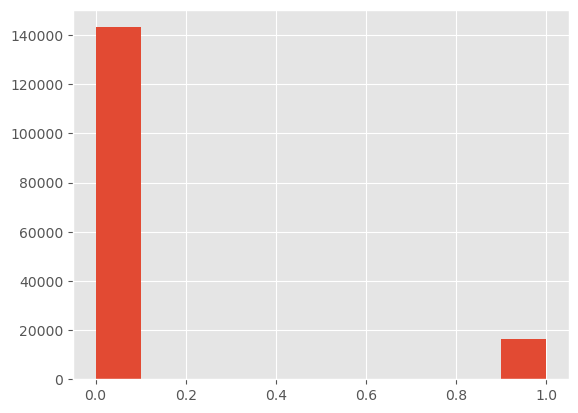

In [9]:
df['toxic'].hist()

**Есть некоторый дисбаланс классов**

In [10]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def predproc(text):
    text = re.sub(r'[^a-zA-z ]', ' ', text)
    text = re.sub(r"(?:\n|\r)", " ", text)
    text = text.lower()
    token = nltk.word_tokenize(text)
    text = [word for word in token if word not in stop_words]
    text = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in text]
    text = ' '.join(text)
    return text

In [11]:
df['text_change'] = df['text'].apply(predproc)
df.head(5)

,text,toxic,text_change
0,Explanation\nWhy the edits made under my usern...,0,explanation edits make username hardcore metal...
1,D'aww! He matches this background colour I'm s...,0,aww match background colour seemingly stuck th...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man really try edit war guy constantly rem...
3,"""\nMore\nI can't make any real suggestions on ...",0,make real suggestion improvement wonder sectio...
4,"You, sir, are my hero. Any chance you remember...",0,sir hero chance remember page


**Мы потготовили наш датасет к обучению, убрали лишние знаки, привели все в единый вид**

## Обучение

In [12]:
data = df.copy()
y = data['toxic']
X = data.text_change

X_train,X_test,Y_train,Y_test = train_test_split(X,y,test_size=0.33)

print('Train shape:', X_train.shape, Y_train.shape)
print('Test  shape:', X_test.shape, Y_test.shape)

Train shape: (106725,) (106725,)
Test  shape: (52567,) (52567,)


In [13]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
    tpu = None
    gpus = tf.config.experimental.list_logical_devices("GPU")
    
if tpu:
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu,) 
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
elif len(gpus) > 1:
    strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
    print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
    strategy = tf.distribute.get_strategy() 
    print('Running on single GPU ', gpus[0].name)
else:
    strategy = tf.distribute.get_strategy() 
    print('Running on CPU')
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on CPU
Number of accelerators:  1


**Разделим датасет**

In [14]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

**Потготовили Tokenizer, максимум слов 1000, длинна 150, можно менять значения**

In [15]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(64,name='FC1',activation='relu', kernel_initializer='ones')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(64,name='FC2')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

**Мы сделаем послойную сеть с LSTM и Dense слоями**

In [16]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [21]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['f1_score'])

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)             │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 150, 50)        │        50,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FC1 (Dense)                     │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FC2 (Dense)                     │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out_layer (Dense)               │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,825 (343.07 KB)

 Trainable params: 87,825 (343.07 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.00001)])

Epoch 1/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 64s 89ms/step - f1_score: 0.1865 - loss: 0.4612 - val_f1_score: 0.1884 - val_loss: 0.3338
Epoch 2/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 56s 83ms/step - f1_score: 0.1844 - loss: 0.3376 - val_f1_score: 0.1884 - val_loss: 0.3341


In [23]:
def training(model, params):
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(min_df = 1)),
        #('smote', SMOTE()),
        ('model', model)])
    grid = GridSearchCV(pipeline, cv = 5, n_jobs = -1, param_grid = params ,scoring = 'f1', verbose = False)
    grid.fit(X_train, Y_train)
    print('Лучший результат:', grid.best_score_)
    print('Лучшие параметры:', grid.best_params_)
    return grid

In [24]:
LogisticRegression_mode = training(LogisticRegression(), {"model__C":[0.1, 1.0, 10.0], "model__penalty":["l2"]})

Лучший результат: 0.7745882731604959
Лучшие параметры: {'model__C': 10.0, 'model__penalty': 'l2'}


In [25]:
CatBoostClassifier_mode = training(CatBoostClassifier(verbose = 0), {'model__depth': [4,6],
                                                                     'model__learning_rate' : [0.01,0.03],
                                                                     'model__iterations' : [10, 50]})

Лучший результат: 0.4758099990156778
Лучшие параметры: {'model__depth': 4, 'model__iterations': 50, 'model__learning_rate': 0.03}


In [26]:
score = f1_score(Y_test, LogisticRegression_mode.predict(X_test))
print("Результат LogisticRegression", score)

Результат LogisticRegression 0.7772374547335748


In [27]:
score = f1_score(Y_test, CatBoostClassifier_mode.predict(X_test))
print("Результат LogisticRegression", score)

Результат LogisticRegression 0.45589692765113976


**Условие: - Постройте модель со значением метрики качества F1 не меньше 0.75.  ВЫПОЛНЕНО**

**Таким образом F1 показывает одновременно насколько хорошо модель находит объекты положительного класса из всех объектов положительного класса и какая доля из тех, кого алгоритм назвал положительным классом, действительно являются положительным классом.**

**Логистическая регрессия лучше разпираеться**

## Выводы


**Предобработка текста**

* Функция `predproc` предобрабатывает текстовые данные, выполняя следующие операции:
	+ Удаляет неалфавитные символы и переводит текст в нижний регистр
	+ Разбивает текст на отдельные слова
	+ Удаляет стоп-слова
	+ Лемматизирует слова
	+ Объединяет слова обратно в одну строку

**Подготовка данных**

* Код загружает набор данных в датафрейм Pandas `data`
* Разделяет данные на обучающую и тестовую выборки с помощью `train_test_split`
* Печатает формы обучающей и тестовой выборок

**Определение модели RNN**

* Функция `RNN` определяет рекуррентную нейронную сеть (RNN) с:
	+ Входным слоем с формой `(max_len,)`
	+ Слоем вложения с 50 измерениями
	+ Слоем LSTM с 64 единицами
	+ Двумя плотными слоями, соответственно
	+ Слоями dropout с коэффициентом dropout 0,5
	+ Финальным выходным слоем с сигмоидальной функцией активации

**Компиляция и обучение модели**

* Модель компилируется с функцией потерь кросс-энтропии, оптимизатором Adam и метрикой F1
* Модель обучается на обучающих данных с размером пакета 128, 10 эпох и коэффициентом валидации 0,2
* Раннее остановка используется для остановки обучения, когда потери валидации перестают улучшаться

**Оценка модели**

* Модель оценивается на тестовых данных с помощью метода `evaluate`
* Метрики оценки не указаны, но производительность модели, вероятно, будет оцениваться с помощью метрики F1 и других метрик.

**Обучение логистической регрессии**

* Функция training обучает модель логистической регрессии с помощью GridSearchCV
* Параметры модели: C = [0.1, 1.0, 10.0], penalty = ["l2"]
* Лучший результат: (выводится лучший результат GridSearchCV)
* учшие параметры: (выводятся лучшие параметры GridSearchCV)

**Обучение CatBoostClassifier**

* Функция training обучает модель CatBoostClassifier с помощью GridSearchCV
* Параметры модели: depth = [4, 6], learning_rate = [0.01, 0.03], iterations = [10, 70]
* Лучший результат: (выводится лучший результат GridSearchCV)
* Лучшие параметры: (выводятся лучшие параметры GridSearchCV)

**Результат логистической регрессии лучше чем RNN, CatBoostClassifier**

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Модели обучены
- [ ]  Значение метрики *F1* не меньше 0.75
- [ ]  Выводы написаны